<a href="https://colab.research.google.com/github/paula-rj/StratoPy/blob/main/superposicion_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código para plotear la superposición de datos de CloudSat con el producto microfísica de día de GOES.

# 1)  Sincronizar con Drive 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is p

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
%pwd

/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

# Instalación de librerías
Es necesario el archivo requirements.txt, alli estan almacenados los nombres de todas las librerías que se deben instalar en Colab, necesarias para correr el programa.

In [18]:

#%pip install -r requirements.txt
# !pip install pyhdf
# !pip install geopandas
# !pip install netcdf4
# !pip install h5py
# !pip install pyorbital
# !pip install pyspectral

In [19]:
#Librerias generales
import sys
from scipy import interpolate
import numpy as np
import pprint
import pandas as pd
import time as t
#%%%%%%%
#PyHDF
import h5py
# import pyhdf
# from pyhdf.HDF import *
# from pyhdf.VS import *
# from pyhdf.SD import SD, SDC  
#%%%
#Librerias geo
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
#%%I/*
import geopandas as gpd
#%%
from netCDF4 import Dataset
#Librerias para calcular zenith
#%%
import calendar
import logging
from datetime import datetime
#%%
from pyorbital import astronomy
from pyspectral.near_infrared_reflectance import Calculator
#Librerias para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# Script
Nota: antes de correrlo, volver a correr las 3 primeras celdas (importar desde Kaggle) si no, no anda. 
Nota 2: estoy usando docstrings estilo numpy para documentar las funciones (creo que el PEP8 no dice nada al respecto)

In [ ]:
#%%
#Recorte
def muestreo(x,y,z,esc=1,kind='cubic'): #requiere numpy y scipy
""" 
Función necesaria para remuestrar la banda 3 del GOES, 
que tiene tamaño de pixel 1000 m a diferencia del resto que tiene tamaño de pixel 2000 m.

Parameters
----------
x:  range_like
  range(0,ancho o cantidad de columnas de la imagen)
y:  range_like
  range(0,alto o cantidad de filas de la imagen)
z: array_like
  matriz de la imagen original
esc: int
  escala
kind: str
  tipo de interpolación

Returns:
-------
f: array_like
  imagen con el nuevo tamaño

"""
    f = interpolate.interp2d(x, y, z, kind='cubic')
    xnew = np.arange(x[0],x[-1], (x[1]-x[0])/esc)
    ynew = np.arange(y[0],y[-1], (y[1]-y[0])/esc)
    return f(xnew, ynew)

def recorte(data_path,x0 = -555469.8930323641, y0 = 0.0):
    #lat =  0. -> y0
    #lon = -80. -> x0
  """
  Funcion que recorta la una imagen tipo CMI de GOES.
  Parameters
  ----------
  data_path: str. 
  Direccion de los datos GOES.
  x0: float. 
  Coordenada x del limite superior izquierdo en m.
  y0: float. 
  Coordenada y del limite superior izquierdo en m.
  
  Returns
  -------
  im_rec: matriz con los elementos del recorte
  
  Example
  -------
  """
  data = Dataset(data_path)
  metadato = data.variables
  banda = metadato['band_id'][:].data[0]
  print('banda =', banda)
  image = np.array(metadato['CMI'][:].data)

  #Parámetros para el recorte
  filas = 1440 # filas del recorte para la de referencia
  columnas = 1440 # filas del recorte para la de referencia
  
  if int(banda)==3:
    x,y, image = muestreo(range(0,10848),range(0,10848),image,esc=0.5)
    psize= 2000
    N = 5424 #esc da 1
    print(f"Tamaño banda 3 pre-recorte = {image.shape}")
  else: #bandas 7 y 13
    psize = 2000 #tamaño del pixel en km
    N = 5424 #esc da 1
  
  img_extentr = [x0,x0+columnas*psize,y0-filas*psize,y0] #en proyeccion goes
  print('extent rec en proyeccion goes:', img_extentr)
  
  esc= int(N/image.shape[0])
  Nx = int(columnas/esc) #numero de puntos del recorte en x
  Ny = int(filas/esc) #numero de puntos del recorte en x
  f0 = int((-y0/psize+N/2-1.5)/esc) #fila del angulo superior izquierdo
  c0 = int((x0/psize+N/2+.5)/esc) #columna del angulo superior izquierdo
  f1 = int(f0+Ny) #fila del angulo inferior derecho
  c1 = int(c0+Nx) #columna del angulo inferior derecho
  print('coordenadas filas, col: ', f0,c0,f1,c1)
  
  im_rec = image[f0:f1,c0:c1]
  return im_rec

banda = 3
Tamaño banda 3 pre-recorte = (5424, 5424)
extent rec en proyeccion goes: [-555469.8930323641, 2324530.106967636, -2880000.0, 0.0]
coordenadas filas, col:  2710 2434 4150 3874
banda = 7
extent rec en proyeccion goes: [-555469.8930323641, 2324530.106967636, -2880000.0, 0.0]
coordenadas filas, col:  2710 2434 4150 3874
banda = 13
extent rec en proyeccion goes: [-555469.8930323641, 2324530.106967636, -2880000.0, 0.0]
coordenadas filas, col:  2710 2434 4150 3874
(1440, 1440) (1440, 1440) (1440, 1440)


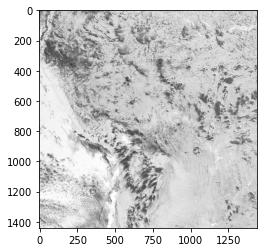

In [ ]:
#%%
#Hago los recortes
rec03 = recorte('/content/gdrive/MyDrive/Kaggle/OR_ABI-L2-CMIPF-M3C03_G16_s20190021800363_e20190021811129_c20190021811205.nc')
rec07 = recorte("/content/gdrive/MyDrive/Kaggle/OR_ABI-L2-CMIPF-M3C07_G16_s20190021800363_e20190021811141_c20190021811202.nc")
rec13 = recorte("/content/gdrive/MyDrive/Kaggle/OR_ABI-L2-CMIPF-M3C13_G16_s20190021800363_e20190021811141_c20190021811221.nc")
#%%
#Comprobamos tamaños
print(rec03.shape, rec07.shape, rec13.shape)
#%%
#hacemos un plot asi nomas para ver que esté bien
plt.figure()
vmin=rec03.min()
vmax=rec03.max()
img=plt.imshow(rec03,vmin=vmin,vmax=vmax,cmap='Greys') #emisivas
plt.show()

#DA BIEN PARA BANDAS 7 Y 13, LA 3 CREO QUE NO ME DA IGUAL

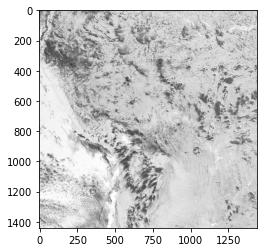

In [ ]:
#%%
#hacemos un plot asi nomas para ver que esté bien
plt.figure()
vmin=rec03.min()
vmax=rec03.max()
img=plt.imshow(rec03,vmin=vmin,vmax=vmax,cmap='Greys') #emisivas
plt.show()

#DA BIEN PARA BANDAS 7 Y 13, LA 3 CREO QUE NO ME DA IGUAL

In [ ]:
#%%
#Calculamos zenith para banda 7
def solar_7(ch7,ch13, latlon_extent):
  """"
  Parameters
  ----------
  ch7: matriz (recortada) del canal 7
  ch13: matriz (recortada) del canal 13
  latlon_extent: list
  Lista [x1,y1,x2,y2] de los bordes de la imagen en latitud, longitud donde
      x1=longitud de más al oeste
      y1=latitud de más al sur (punto y inferior)
      x2 = longitud de más al este
      y2=latitud de más al norte (punto y superior)

  Returns
  -------
  data2b: matriz con el cálculo de zenith pixel a pixel
  """
#Calculo del ángulo del sol para banda 7
  lat = np.linspace(latlon_extent[3], latlon_extent[1], ch7.shape[0])
  lon = np.linspace(latlon_extent[0], latlon_extent[2], ch7.shape[1])
  print(lat.shape)
  print(lon.shape)
  zenith = np.zeros((ch7.shape[0], ch7.shape[1]))
  # Calculate the solar zenith angle
  utc_time = datetime(2019, 1, 2, 18, 00) 
  for x in range(len(lat)):
    for y in range(len(lon)):
      zenith[x,y] = astronomy.sun_zenith_angle(utc_time, lon[y], lat[x])
  refl39 = Calculator(platform_name='GOES-16', instrument='abi', band='ch7')
  data2b = refl39.reflectance_from_tbs(zenith, ch7, ch13)
  return data2b

#%%
latlon_extent=[-80,-30,-50,0] #lat y longs del recorte
rec07b = solar_7(rec07, rec13, latlon_extent)
rec07b.shape

(1440,)
(1440,)


(1440, 1440)

In [ ]:
#%%
def dayRGB(rec03,rec07b,rec13):
# RGB Components
  R = rec03 #banda3
  G = rec07b #banda7 zenith
  B = rec13 #banda13
 
  # Minimuns and Maximuns
  Rmin = 0
  Rmax = 1
 
  Gmin = 0
  Gmax = 0.6
 
  Bmin = 203
  Bmax = 323
 
  #R[R.max] = Rmax
  #G[G.max] = Gmax
  #B[B.max] = Bmax
  
  # Choose the gamma -> STANDARIZADAS
  gamma_R = 1
  gamma_G = 2.5
  gamma_B = 1
 
  # Normalize the data
  R = ((R - Rmin) / (Rmax - Rmin)) ** (1/gamma_R)
  G = ((G - Gmin) / (Gmax - Gmin)) ** (1/gamma_G)
  B = ((B - Bmin) / (Bmax - Bmin)) ** (1/gamma_B) 

  RR = np.copy(R)
  BB = np.copy(B)
  GG = np.copy(G)
 
  RR[RR<0] = 0.
  RR[RR>1] = 1. 
  BB[BB<0] = 0.
  BB[BB>1] = 1.
  GG[GG<0] = 0.
  GG[GG>1] = 1.

# Create the RGB
  RGB = np.stack([R, G, B], axis=2)
  RRGB = np.stack([RR,GG,BB], axis=2) #el axis está para que el shape sea fil col dim y no dim col fil
  print(RGB.shape)
  return RRGB

(1440, 1440, 3)


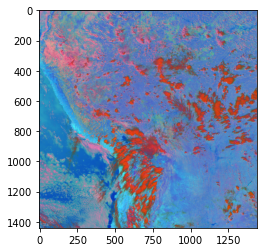

In [ ]:
RRGB = dayRGB(rec03,rec07b,rec13)
#%%
plt.figure()
plt.imshow(RRGB)
plt.show()
#DA bien el grafico

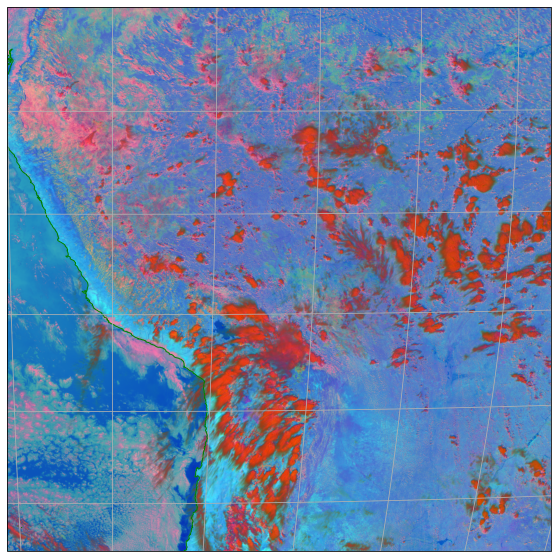

In [ ]:
#%%
#ploteo
import matplotlib.pyplot as plt
crs=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0)
fig_dims = (10, 10)
fig, axis = plt.subplots(figsize=fig_dims)
rec_goes_extent = [-555469.8930323641, 2324530.106967636, -2880000.0, 0.0]#[-21609.527, -3656.536,  1443656.536, -1418390.473]
axis = plt.axes(projection=crs)
axis.gridlines()
axis.coastlines(resolution='10m',color='green') 
plt.imshow(RRGB, origin='upper', extent=rec_goes_extent)
#DA BIEN!!!! (creo, ver banda 3)
#%%
#ds1 = Dataset("C:/Users/Daniel/OR_ABI-L2-CMIPF-M3C13_G16_s20190021800363_e20190021811141_c20190021811221.nc")
#print(ds1.variables.keys())
#%%%
#H = ds1.variables['goes_imager_projection'].perspective_point_height
#x = ds1.variables['x'][:]
#X_goes_proj = x*H
#print(X_goes_proj)
#%%

In [ ]:
#Comprobamos la saturacion
RRGB.max(), RRGB.min()

(1.0, 0.0)

In [ ]:
#CON CLOUDSAT
class CldClass:
  def __init__(self,path_total):
    self.path_total = path_total
    self.file_name = os.path.split(self.path_total)[-1]
    date = self.file_name.split('_')[0]
    self.year = date[:4]
    self.julian_day = date[4:7]
    self.hour_utc = date[7:9]
    self.light=''
    if int(self.hour_utc)>10:
      self.light='day'
    else:
      self.light='night'
  
  def open_cldclass(self, sur=True):
    """
      Función que toma un path donde debe estar el archivo CLDCLASS de Cloudsat y devuelve un dataframe de Pandas 
    con los datos del archivo cldclass guardados en columnas del dataframe: latitud, longitud, capa0, capa1,..., capa9;
    con cada tipo de nube segun cada capa.
    Parameters:
    -----------
    sur : Bool. Si se quiere abrir solo la parte de sudamerica. Default=True.

    Returns:
    -----------
    layers_df: Pandas Dataframe lat, lon, tipo de nube en cada una de las capas (son 10)
    """
  #Read v data
    hdf_file = HDF(self.path_total, HC.READ)
    vs = hdf_file.vstart()
    vdata = vs.vdatainfo() #es una lista de tuplas. acá estan lat y long y cloud layers

    vd_lat = vs.attach('Latitude', write=0)
    lat = vd_lat[:]
    vd_lat.detach

    vd_lon = vs.attach('Longitude', write=0)
    lon = vd_lon[:]
    vd_lon.detach
    vs.end() 
    #hdf_file.close()

    latitud = np.array(lat).flatten()
    longitud = np.array(lon).flatten()

    #Read sd data
    file = SD(self.path_total, SDC.READ)  
    start_point=0
    end_point=36951
    if sur==True:
      if self.light=='night':
        end_point = 6000 
      else:
        end_point=20000
        if self.hour_utc==(15):
          start_point=6000
        else: #16,17,18 utc
          start_point=10000
      latitud = latitud[start_point:end_point]
      longitud = longitud[start_point:end_point]
      cld_layertype= file.select('CloudLayerType')[start_point:end_point] 
    else: #grafica toda la orbita
      cld_layertype= file.select('CloudLayerType')[:]

    layers_df = pd.DataFrame({'Longitude': longitud, 'Latitude': latitud, 
                            'capa0':cld_layertype[:,0], 'capa1':cld_layertype[:,1],
                            'capa2':cld_layertype[:,2], 'capa3':cld_layertype[:,3],
                            'capa4':cld_layertype[:,4], 'capa5':cld_layertype[:,5],
                            'capa6':cld_layertype[:,6], 'capa7':cld_layertype[:,7],
                            'capa8':cld_layertype[:,8], 'capa9':cld_layertype[:,9]})
    
    return layers_df

  def plot_cldclass_geos(self,layers_data, capa_n):
    """
      Función que grafica los tipos de nubes en la capa asignada en la pasada del Cloudsat.
    Parameters:
    -----------
    layers_data : Pandas Dataframe. 
      Dataframe de Pandas que contiene Latitud,Longitud,y la capa que se quiere graficar.
    capa_n : int
      Numero de capaque se quiere graficar. Van de 0 a 9.

    Returns:
    -----------
    Plot. Tipo de nube en la capa 9 con órbita proyectada en proyeccion geoestacionaria de GOES16, 
    con mapa de costas de fondo.
    """
    capa_str = 'capa' + str(capa_n)

    #Generamos geodataframe a partir del pd dataframe de entrada
    geo_df = gpd.GeoDataFrame(layers_data.loc[:,['Longitude','Latitude',capa_str]], 
                            geometry=gpd.points_from_xy(layers_data.Longitude, layers_data.Latitude))
    geo_df.crs = {'init': 'epsg:4326'} # EPSG 4326 corresponds to coordinates in latitude and longitude
    #Reprojecting into GOES16 geostationary projection 
    geodf_GOESproj = geo_df.to_crs("+proj=geos +h=35786023.0 +lon_0=-75.0")
    crs=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0) #proyeccion geoestacionaria para Goes16
    fig_dims = (10, 10)
    fig, axis = plt.subplots(figsize=fig_dims)
    axis = plt.axes(projection=crs)
    axis.gridlines 
    axis.coastlines(resolution='10m',color='blue') 
    sns.scatterplot(x='Longitude', y='Latitude', data=geodf_GOESproj, hue=capa_str,
                    palette='bright',s=2, transform=ccrs.PlateCarree())
    axis.set_title("""year {}; day {}; hour {}; {}""".format(self.year, self.julian_day, self.hour_utc,self.light))
    plt.show()

  def plotlatlon_cld(self, capa_n, layers_data_df):
    """
       Grafica la capa capa_n con latitud en el eje y y longitud en el eje x, sin ninguna proyeccion
        Parameters
        ----------
        capa_n : int
            El numero de capa que quiero dibujar. Entre 0 y 9.
        layers_data_df : pandas DataFrame
            DataFrame de Pandas o Geopandas que incluya latitud, longitud y la capa que vamos a dibujar.
        Returns
        ----------
        Plot."""

    capa_str = 'capa' + str(capa_n)
    fig_dims = (6, 6)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.scatterplot(x='Longitude', y='Latitude', data=layers_data_df, hue='capa2',palette='bright',marker='o', s=1)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
#%%

In [ ]:
day2 = CldClass('/content/gdrive/MyDrive/Kaggle/2019002175851_67551_CS_2B-CLDCLASS_GRANULE_P1_R05_E08_F03.hdf')

In [ ]:
day2df = day2.open_cldclass() 

In [ ]:
geo_df = gpd.GeoDataFrame(day2df.loc[:,['Longitude','Latitude','capa0']], 
                            geometry=gpd.points_from_xy(day2df.Longitude, day2df.Latitude))
geo_df.crs = {'init': 'epsg:4326'} # EPSG 4326 corresponds to coordinates in latitude and longitude
    #Reprojecting into GOES16 geostationary projection 
geodf_GOESproj = geo_df.to_crs("+proj=geos +h=35786023.0 +lon_0=-75.0") 

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


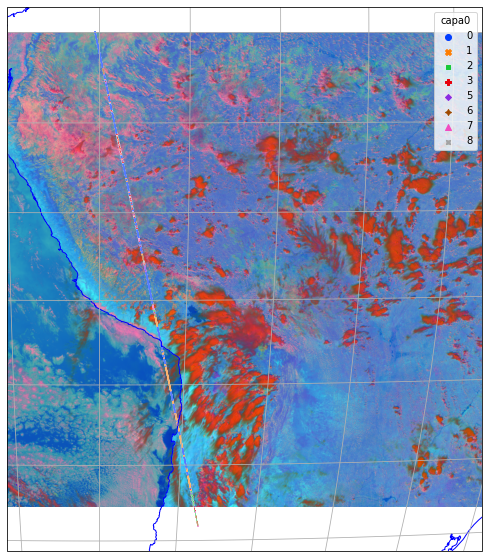

In [ ]:
fig_dims = (10, 10)
fig, axis = plt.subplots(figsize=fig_dims)
img_extentr = [-555469.8930323641, 2324530.106967636, -2880000.0, 0.0]
axis = plt.axes(projection=crs)
axis.gridlines()
axis.coastlines(resolution='10m',color='blue') 
plt.imshow(RRGB, origin='upper', extent=img_extentr)
sns.scatterplot(x='Longitude', y='Latitude', data=geodf_GOESproj.iloc[5500:8500,:], hue='capa0',style='capa0', palette="bright",s=2, transform=ccrs.PlateCarree())

Ahora quiero hacer un cuadrito donde para cada punto donde hay una nube me muestre la fila y columna.

In [ ]:
def latlon2geos(lat, lon, lon0=-75., Re=6378000., Rp=6356000., h=35786000.):
    
    '''
    Transforma coordenadas de latitud/longitud a x/y en proyeccion geoestacionaria
    En base a 5.2.8.1 de PUG3
    Parameters
    ----------
    lat : float
        latitud
    lon : float
        longitud
    lon0 : float
        longitud del satélite y origen del sistema de coordenadas planas
    Re: float
    Rp: float
    h : float
        altura de satélite
    Returns
    -------
    x : float
       coordenada horizontal, en radianes 
    y : float
       coordenada vertical, en radianes. Paralelo al eje terrestre 
    '''

    H = Re + h # radio orbital del satelite
    e = 0.0818191910435 # excentricidad 
    gr2rad = np.pi/180
    
    latc = np.arctan( (Rp/Re)**2 * np.tan(lat*gr2rad))
    
    rc = Rp / (1 - (e * np.cos(latc))**2 )**.5
    
    print(latc,rc)
    
    
    s = np.array( [H - rc * np.cos(latc) * np.cos((lon-lon0)*gr2rad), \
                 - rc * np.cos(latc) * np.sin((lon-lon0)*gr2rad), \
                   rc * np.sin(latc) ])
  
    print(s)
        
    ang = np.array( [ np.arcsin(-s[1]/np.linalg.norm(s)), \
                     np.arctan(s[2]/s[0]) ] )
    
    # print (ang)
          
    return ang[0], ang[1]

In [ ]:
from itertools import *

A cada lat, ln le tengo que aplicar la funcion esta, multiplicar por la altura obteniendo x0, y0 y hacer 

fil = -round((offset[0] *altura + y0)/p_size)
col = round((offset[1] *altura + x0)/p_size)

Defino otra función

In [ ]:
def get_filcol(lat,lon, metadato):
  altura = 35786000.
  p_size = 2004. #1.1 km es el tamaño de pixel de cloudsat
  x, y = latlon2geos(lat, lon, lon0=-75., Re=6378000., Rp=6356000., h=35786000.)
  x0, y0 = x*altura, y*altura
  offset = np.array([metadato['x'].add_offset, metadato['y'].add_offset])
  fil = -round((offset[0] *altura + y0)/p_size) #obs! se simplifican las alturas
  col = round((offset[1] *altura + x0)/p_size)
  return fil, col

In [ ]:
def get_filcol2(lat,lon, metadato):
  scale_factor = metadato['x'].scale_factor
  altura = 35786000.
  p_size = 2004. #1.1 km es el tamaño de pixel de cloudsat
  x, y = latlon2geos(lat, lon, lon0=-75., Re=6378000., Rp=6356000., h=35786000.)
  offset = np.array([metadato['x'].add_offset, metadato['y'].add_offset])
  fil = -int((offset[0]  + y)/scale_factor) #obs! se simplifican las alturas
  col = int((offset[1] + x)/scale_factor)
  return fil, col

In [ ]:
ds = Dataset("/content/gdrive/MyDrive/Kaggle/OR_ABI-L2-CMIPF-M3C13_G16_s20190021800363_e20190021811141_c20190021811221.nc")
metadato = ds.variables
get_filcol2(0., -80., metadato)

0.0 6377382.155007649
[35810885.70947647   555825.47850535        0.        ]


(2711, 2434)

In [ ]:
metadato.keys()

dict_keys(['CMI', 'DQF', 't', 'y', 'x', 'time_bounds', 'goes_imager_projection', 'y_image', 'y_image_bounds', 'x_image', 'x_image_bounds', 'nominal_satellite_subpoint_lat', 'nominal_satellite_subpoint_lon', 'nominal_satellite_height', 'geospatial_lat_lon_extent', 'band_wavelength', 'band_id', 'total_number_of_points', 'valid_pixel_count', 'outlier_pixel_count', 'min_brightness_temperature', 'max_brightness_temperature', 'mean_brightness_temperature', 'std_dev_brightness_temperature', 'esun', 'kappa0', 'planck_fk1', 'planck_fk2', 'planck_bc1', 'planck_bc2', 'algorithm_dynamic_input_data_container', 'percent_uncorrectable_GRB_errors', 'percent_uncorrectable_L0_errors', 'earth_sun_distance_anomaly_in_AU', 'processing_parm_version_container', 'algorithm_product_version_container'])

In [ ]:
cs_lat = geodf_GOESproj.iloc[6000:8500,:].Latitude.to_numpy()
cs_lon = geodf_GOESproj.iloc[6000:8500,:].Longitude.to_numpy()
cs_lat_lon = list(zip(cs_lat, cs_lon))
print(cs_lat_lon)

[(-24.19857406616211, -69.85821533203125), (-24.188920974731445, -69.86054229736328), (-24.17926597595215, -69.86286926269531), (-24.16961097717285, -69.86519622802734), (-24.159955978393555, -69.86752319335938), (-24.150300979614258, -69.86984252929688), (-24.14064598083496, -69.8721694946289), (-24.130990982055664, -69.87449645996094), (-24.121337890625, -69.87682342529297), (-24.111682891845703, -69.87914276123047), (-24.102027893066406, -69.8814697265625), (-24.09237289428711, -69.8837890625), (-24.082717895507812, -69.88611602783203), (-24.073062896728516, -69.88844299316406), (-24.06340789794922, -69.89076232910156), (-24.053752899169922, -69.8930892944336), (-24.044097900390625, -69.8954086303711), (-24.034442901611328, -69.8977279663086), (-24.02478790283203, -69.90005493164062), (-24.0151309967041, -69.90237426757812), (-24.005475997924805, -69.90469360351562), (-23.995820999145508, -69.90701293945312), (-23.98616600036621, -69.90933990478516), (-23.976511001586914, -69.911659

In [ ]:
f = np.zeros(len(cs_lat_lon), dtype=int)
c = np.zeros(len(cs_lat_lon), dtype=int)

for i in range(len(cs_lat_lon)):
  f[i], c[i] =  get_filcol2(cs_lat[i], cs_lon[i], metadato)

-0.41976695437119327 6373815.736703643
[36366955.53859868  -521634.05579866 -2597633.62886653]
-0.4195992497970992 6373818.4143769
[36366498.12049199  -521437.85481156 -2596658.56440939]
-0.41943151237703047 6373821.091771525
[36366040.78678895  -521241.61051556 -2595683.23478035]
-0.4192637752475753 6373823.768358063
[36365583.62371717  -521045.31517225 -2594707.83266216]
-0.4190960384086456 6373826.444136212
[36365126.63129243  -520848.96880076 -2593732.35808233]
-0.41892830186015323 6373829.119105675
[36364669.87885958  -520653.34364778 -2592756.81106834]
-0.41876056560201014 6373831.793266154
[36364213.22774996  -520456.89533822 -2591781.19164771]
-0.41859282963412797 6373834.4666173505
[36363756.74733459  -520260.39605793 -2590805.49984794]
-0.4184251270926361 6373837.138631083
[36363300.52358395  -520063.83811978 -2589829.92846626]
-0.4182573917049539 6373839.810362978
[36362844.45379668  -519868.00943251 -2588854.09200503]
-0.4180896566072678 6373842.481284695
[36362388.4855001 

In [ ]:
f

array([3984, 3984, 3983, ..., 2712, 2711, 2711])

In [ ]:
c

array([2966, 2966, 2966, ..., 2700, 2700, 2700])

In [ ]:
result = starmap(
    lambda x, y: get_filcol(x,y, metadato), 
    cs_lat_lon
    )

In [ ]:
print(list(result))

Se han truncado las últimas 5000 líneas del flujo de salida.
[36366955.53859868  -521634.05579866 -2597633.62886653]
-0.4195992497970992 6373818.4143769
[36366498.12049199  -521437.85481156 -2596658.56440939]
-0.41943151237703047 6373821.091771525
[36366040.78678895  -521241.61051556 -2595683.23478035]
-0.4192637752475753 6373823.768358063
[36365583.62371717  -521045.31517225 -2594707.83266216]
-0.4190960384086456 6373826.444136212
[36365126.63129243  -520848.96880076 -2593732.35808233]
-0.41892830186015323 6373829.119105675
[36364669.87885958  -520653.34364778 -2592756.81106834]
-0.41876056560201014 6373831.793266154
[36364213.22774996  -520456.89533822 -2591781.19164771]
-0.41859282963412797 6373834.4666173505
[36363756.74733459  -520260.39605793 -2590805.49984794]
-0.4184251270926361 6373837.138631083
[36363300.52358395  -520063.83811978 -2589829.92846626]
-0.4182573917049539 6373839.810362978
[36362844.45379668  -519868.00943251 -2588854.09200503]
-0.4180896566072678 6373842.481284

In [ ]:
type(result)

itertools.starmap

to do:
- armar la tabla con puntos rgb
- estudiar comparacion entre los puntos
- comparar con cloudsat

In [ ]:
day2df['fil_col'] = day2df.apply(lambda x: get_filcol2(x.Latitude, x.Longitude, metadato), axis=1)

Se han truncado las últimas 5000 líneas del flujo de salida.
-0.16787286490685652 6376782.286391159
[35880172.53141069  -204066.10286072 -1065467.83090702]
-0.1677047874776955 6376783.475544702
[35879985.0201351   -203842.67651465 -1064411.28801081]
-0.16753671017789584 6376784.663551783
[35879797.66840932  -203618.39417426 -1063354.71527302]
-0.16736863300733276 6376785.850412269
[35879610.53049627  -203394.92941865 -1062298.1127233 ]
-0.1672005394293823 6376787.036242631
[35879423.56160392  -203171.44607103 -1061241.37643155]
-0.16703246251693038 6376788.220809419
[35879236.79706597  -202947.94300838 -1060184.71434408]
-0.16686438573334036 6376789.404229214
[35879050.21921606  -202724.42082236 -1059128.0225337 ]
-0.16669629254202625 6376790.58661815
[35878863.81045809  -202500.88009978 -1058071.19706154]
-0.16652821601579793 6376791.767743453
[35878677.60602032  -202277.31972487 -1057014.44589145]
-0.16636012308162088 6376792.947837407
[35878491.57072195  -202053.74085039 -1055957.56

In [ ]:
day2df.iloc[6000:8500,:].head(25)

,Longitude,Latitude,capa0,capa1,capa2,capa3,capa4,capa5,capa6,capa7,capa8,capa9,fil_col
6000,-69.858215,-24.198574,0,0,0,0,0,0,0,0,0,0,"(3984, 2966)"
6001,-69.860542,-24.188921,0,0,0,0,0,0,0,0,0,0,"(3984, 2966)"
6002,-69.862869,-24.179266,0,0,0,0,0,0,0,0,0,0,"(3983, 2966)"
6003,-69.865196,-24.169611,0,0,0,0,0,0,0,0,0,0,"(3983, 2966)"
6004,-69.867523,-24.159956,0,0,0,0,0,0,0,0,0,0,"(3983, 2966)"
6005,-69.869843,-24.150301,0,0,0,0,0,0,0,0,0,0,"(3982, 2966)"
6006,-69.872169,-24.140646,0,0,0,0,0,0,0,0,0,0,"(3982, 2966)"
6007,-69.874496,-24.130991,0,0,0,0,0,0,0,0,0,0,"(3981, 2966)"
6008,-69.876823,-24.121338,0,0,0,0,0,0,0,0,0,0,"(3981, 2966)"
6009,-69.879143,-24.111683,0,0,0,0,0,0,0,0,0,0,"(3980, 2966)"


In [ ]:
def superpix(cs_fila,cs_col,lat_lon_extent, GOES_path_list):
  '''
  Parameters
  ----------
  cs_fila: int
  cs_col: int
  Columna en la que se encuentra el pixel de Cloudsat
  GOES_path_list: list[str]
  direcciónes en la que se encuentran los archivos de GOES

  Returns:
  -------
  superpix: np arrayEl punto de cloudsat + superpixel, pero todo de GOES ya en RRGB
  '''
  banda3 = Dataset(GOES_path_list[0])
  banda7 = Dataset(GOES_path_list[1])
  banda13 = Dataset(GOES_path_list[2])
  metadato1 = banda3.variables
  metadato2 = banda7.variables
  metadato3 = banda13.variables
  superpix1 = metadato1['CMI'][:].data[cs_fila-50:cs_fila+51,cs_col-50:cs_col+51]
  superpix2 = metadato2['CMI'][:].data[cs_fila-50:cs_fila+51,cs_col-50:cs_col+51]
  superpix3 = metadato3['CMI'][:].data[cs_fila-50:cs_fila+51,cs_col-50:cs_col+51]

  superpix2b = solar_7(superpix2,superpix3,lat_lon_extent)
  
  RGBsuperpix = dayRGB(superpix1, superpix2b, superpix3)
  return RGBsuperpix

In [ ]:
lista_paths = ['/content/gdrive/MyDrive/Kaggle/OR_ABI-L2-CMIPF-M3C03_G16_s20190021800363_e20190021811129_c20190021811205.nc',
              '/content/gdrive/MyDrive/Kaggle/OR_ABI-L2-CMIPF-M3C07_G16_s20190021800363_e20190021811141_c20190021811202.nc',
              '/content/gdrive/MyDrive/Kaggle/OR_ABI-L2-CMIPF-M3C13_G16_s20190021800363_e20190021811141_c20190021811221.nc']
lat_lon_extent = [-69.890762,	-24.111683, -69.879143, -23.976511]
a = superpix(3979, 2965, lat_lon_extent, lista_paths)
a

(101,)
(101,)
(101, 101, 3)


array([[[0.01682538, 0.30560965, 0.72260004],
        [0.0142857 , 0.26839979, 0.72106373],
        [0.01555554, 0.24853777, 0.7185033 ],
        ...,
        [0.02888886, 0.74409096, 0.90593594],
        [0.02888886, 0.73586654, 0.8854515 ],
        [0.02888886, 0.72683342, 0.8706001 ]],

       [[0.02031744, 0.27026425, 0.72464854],
        [0.01555554, 0.25456394, 0.72260004],
        [0.01555554, 0.25236794, 0.71901524],
        ...,
        [0.02634918, 0.71630716, 0.89262086],
        [0.02634918, 0.72033536, 0.89057261],
        [0.02634918, 0.7175278 , 0.883403  ]],

       [[0.01936506, 0.25880223, 0.72413635],
        [0.01682538, 0.24676145, 0.72311223],
        [0.01809522, 0.24189931, 0.72106373],
        ...,
        [0.02285712, 0.70351171, 0.90081483],
        [0.02412696, 0.6999531 , 0.90696007],
        [0.02412696, 0.70593335, 0.90542376]],

       ...,

       [[0.03111108, 0.35128216, 0.48139572],
        [0.03238092, 0.35151503, 0.48600489],
        [0.03238092, 0

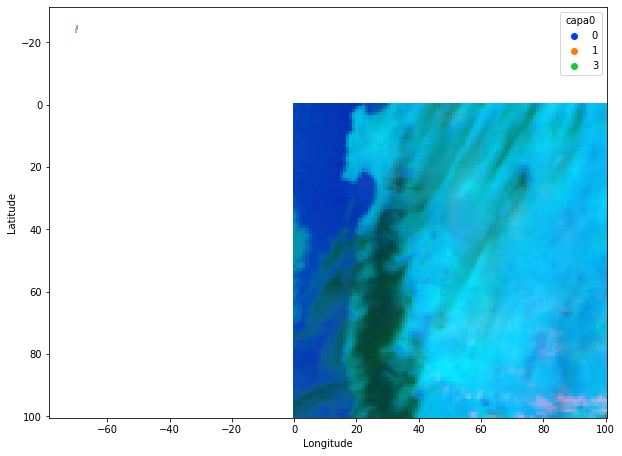

In [ ]:
fig_dims = (10, 10)
fig, axis = plt.subplots(figsize=fig_dims)
plt.imshow(a, vmin=0., vmax=1.,) 
sns.scatterplot(x='Longitude', y='Latitude', data=geodf_GOESproj.iloc[5900:6100,:], hue='capa0', palette="bright",s=2)
plt.show()
#Para cloudsat ahi no hay nubes 

In [ ]:
recRRGB = RRGB[(3979-2711)-50:(3979-2711)+50,(2965-2434)-50:(2965-2434)+50]
recRRGB

In [ ]:
plt.figure()
img=plt.imshow(recRRGB) 
plt.show()

Para cloudsat ahi no hay nada (0). Para GOES, la guia ràpida dice que celeste es Thin, small drops, low cloud, Fog and/or low stratus (dull aqua to gray). Para eumetsat, celeste es sin nubes. GOES no dice nada de sin nubes. 

Veamos alguno donde segun cloudsat exista alguna nube

In [ ]:
day2df.iloc[6000:8500,:].loc[day2df['capa0'] == 1].head(20)

,Longitude,Latitude,capa0,capa1,capa2,capa3,capa4,capa5,capa6,capa7,capa8,capa9,fil_col
6036,-69.941803,-23.850986,1,0,0,0,0,0,0,0,0,0,"(3968, 2963)"
6037,-69.944122,-23.841331,1,0,0,0,0,0,0,0,0,0,"(3967, 2963)"
6038,-69.946442,-23.831675,1,0,0,0,0,0,0,0,0,0,"(3967, 2963)"
6039,-69.948761,-23.822020,1,0,0,0,0,0,0,0,0,0,"(3966, 2963)"
6040,-69.951073,-23.812363,1,0,0,0,0,0,0,0,0,0,"(3966, 2963)"
6041,-69.953392,-23.802708,1,0,0,0,0,0,0,0,0,0,"(3965, 2963)"
6042,-69.955704,-23.793051,1,0,0,0,0,0,0,0,0,0,"(3965, 2963)"
6043,-69.958023,-23.783396,1,0,0,0,0,0,0,0,0,0,"(3964, 2962)"
6044,-69.960335,-23.773739,1,1,0,0,0,0,0,0,0,0,"(3964, 2962)"
6045,-69.962654,-23.764084,1,1,0,0,0,0,0,0,0,0,"(3964, 2962)"


In [ ]:
lat_lon_extent = [-69.976540,	-23.793051, -69.960335, -23.677176]
cir = superpix(3963, 2962, lat_lon_extent, lista_paths)
cir

(101,)
(101,)
(101, 101, 3)


array([[[0.02158728, 0.59484305, 0.67138898],
        [0.01555554, 0.5840496 , 0.67292529],
        [0.0142857 , 0.57191222, 0.67241311],
        ...,
        [0.19269823, 0.71272959, 0.93256557],
        [0.19015855, 0.71211829, 0.92744446],
        [0.18666649, 0.72684026, 0.91617811]],

       [[0.0142857 , 0.59958521, 0.67138898],
        [0.0142857 , 0.58469166, 0.67190117],
        [0.0142857 , 0.57831229, 0.67241311],
        ...,
        [0.19492045, 0.69950409, 0.92693228],
        [0.18920617, 0.67005593, 0.91259331],
        [0.18444426, 0.69219816, 0.91669005]],

       [[0.0142857 , 0.60845343, 0.67241311],
        [0.0142857 , 0.60092485, 0.67343748],
        [0.01333332, 0.59297777, 0.67343748],
        ...,
        [0.18793632, 0.695932  , 0.92898077],
        [0.18063475, 0.66015275, 0.90491158],
        [0.18190458, 0.6700562 , 0.91310555]],

       ...,

       [[0.0349206 , 0.33939622, 0.63144428],
        [0.0444444 , 0.31826025, 0.661659  ],
        [0.04666662, 0

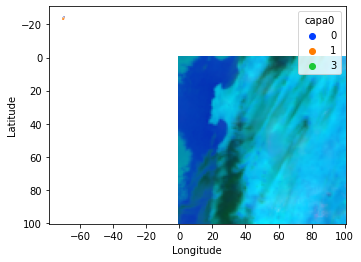

In [ ]:
plt.figure()
plt.imshow(cir)
plt.scatter(x=geodf_GOESproj.)
sns.scatterplot(x='Longitude', y='Latitude', data=geodf_GOESproj.iloc[5950:6100,:], hue='capa0', palette="bright",s=2) 
plt.show()

Veamos uno de nubes medias segun cloudsat, que serian los nros 2=Altostratus, 3 = Altocumulus.

Segun GOES, nubes medias son naranja claro- amarillo.

In [ ]:
day2df.iloc[6000:8500,:].loc[day2df['capa0'] == 3].head(25)

In [ ]:
lat_lon_extent = [-72.455704,-12.881713, -72.445091,-12.833276	]
med = superpix(3411, 2848, lat_lon_extent, lista_paths)
med

In [ ]:
plt.figure()
img=plt.imshow(med) 
plt.show()

veamos para deep convection. Segun GOES, strong convection tiene que ser naranja: Cb, strong convection, likely precip
(orange).

In [ ]:
day2df.iloc[6000:8500,:].loc[day2df['capa0'] == 8].head(15)

In [ ]:
lat_lon_extent = [-72.470551, -12.813901, -72.459946,-12.687962]
dc = superpix(3407, 2847, lat_lon_extent, lista_paths)
dc

In [ ]:
plt.figure()
img=plt.imshow(dc) 
plt.show()